<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/PraktikumPhysik/NormalVerteilungMunzeWerfen.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

# MAS CP
Simulation of non-ramped CP under MAS conditions

In [1]:
# Imports
from subprocess import Popen, PIPE
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
class RunRead():
    def __init__(self):
        self.stdout=None
        self.stderr=None
    def __call__(self,script):
        with open('SIMPSON.tcl','w') as f:f.write(script)
        process = Popen(['simpson', 'SIMPSON.tcl', '-d'], stdout=PIPE, stderr=PIPE)
        self.stdout, self.stderr = process.communicate()            

        if len(self.stderr):print(self.stderr)
        # Collect the results
        with open('SIMPSON.fid','r') as f:
            while True:
                if 'DATA'==f.readline().strip():break
            S=[]
            while True:
                line=f.readline()
                if 'END'==line.strip():break
                S.append(complex(line.strip().split()[0])+complex(line.strip().split()[1])*1j)
        S=np.array(S)
        return S
run_read=RunRead()

In [17]:
script="""
spinsys {
  channels 13C 15N
  nuclei   13C 15N
  dipole   1 2 895 0 0 0
}

par {
  variable index   1
  np               200
  spin_rate        15000
  proton_frequency 400e6
  start_operator   I1x
  detect_operator  I2x
  method           direct
  crystal_file     rep144
  gamma_angles     100
  sw               spin_rate/2
  variable tsw     1e6/sw
  variable tr     1e6/spin_rate
  variable rfF1    75000
  variable rfF2    60000
}

proc pulseq {} {
  global par
  
  reset
  pulse $par(tr) $par(rfF1) x $par(rfF2) x
  store 1

  reset
  acq
  for {set i 1} {$i < $par(np)} {incr i} {
    prop 1
    acq
  }
}
proc main {} {
  global par

  set f [fsimpson]
  fsave $f $par(name).fid
}
"""

In [18]:
S=run_read(script)

(0.0, 1.0)

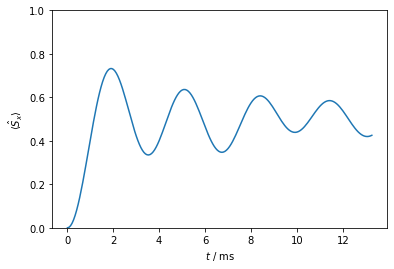

In [19]:
# Plot the results
x=1/15*np.arange(len(S))
fig,ax=plt.subplots()
ax.plot(x,S.real)
ax.set_xlabel(r'$t$ / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')
ax.set_ylim([0,1])

The CP maxes out at 0.73 (1.9 ms), rather than ever yielding a complete transfer of the magnetization. To understand this behavior, we'll simulate with a range of different Euler angles (varying $\beta$)

In [432]:
beta0=np.linspace(0,90,23)
script1=script.replace('rep144','EulerAngle')
S=[]
for beta in beta0:
    with open('EulerAngle.cry','w') as f:f.write(f'1\n0 {beta:.1f} 1')
    S.append(run_read(script1))
S=np.array(S)

(0.0, 1.0)

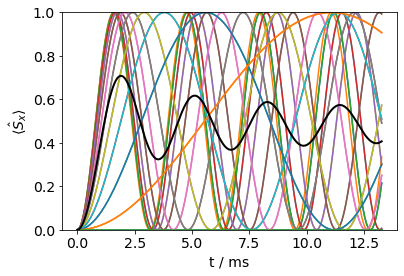

In [433]:
wt=np.sin(beta0*np.pi/180)
wt/=wt.sum()
ax=plt.plot(x,S.real.T)[0].axes
ax.plot(x,(S.real.T*wt).sum(-1),color='black',linewidth=2)
ax.set_xlabel('t / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')
ax.set_ylim([0,1])

## Adiabatic CP

In [438]:
script0="""
spinsys {
  channels 13C 15N
  nuclei   13C 15N
  dipole   1 2 895 0 0 0
}

par {
  variable index   1
  np               400
  spin_rate        15000
  proton_frequency 400e6
  start_operator   I1x
  detect_operator  I2x
  method           direct
  crystal_file     rep144
  gamma_angles     1
  sw               spin_rate/2
  variable tsw     1e6/sw
  variable tr     1e6/spin_rate
  variable rfF1    75000
  variable rfF2    60000
}

proc pulseq {} {
  global par
  
  ADIABATIC SWEEP
}
proc main {} {
  global par

  set f [fsimpson]
  fsave $f $par(name).fid
}
"""

Text(0, 0.5, '$\\omega_1$ / kHz')

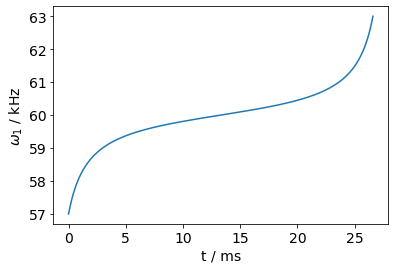

In [439]:
x=1/15*np.arange(400)
swp=np.tan(np.pi/180*np.linspace(-80,80,len(x)))
swp/=(swp[-1]-swp[0])
swp=60000+6000*swp
ax=plt.plot(x,swp/1e3)[0].axes
ax.set_xlabel('t / ms')
ax.set_ylabel(r'$\omega_1$ / kHz')

In [440]:
sweep=''

for amp in swp:
    sweep+=f"""
  pulse $par(tr) $par(rfF1) x {amp:.0f} x
  acq"""

script1=script0.replace('ADIABATIC SWEEP',sweep)

In [410]:
S=run_read(script1)

(0.0, 1.0)

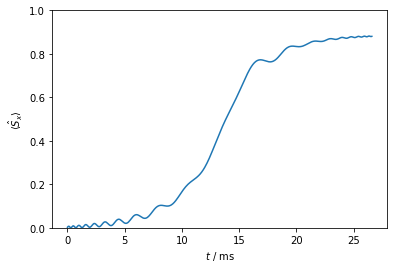

In [411]:
fig,ax=plt.subplots()
ax.plot(x,S.real)
ax.set_xlabel(r'$t$ / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')
ax.set_ylim([0,1])

In [401]:
script1=script1.replace('rep144','EulerAngle')
beta0=np.linspace(0,90,46)
S=[]
for beta in beta0:
    with open('EulerAngle.cry','w') as f:f.write(f'1\n0 {beta} 1')
    S.append(run_read(script1))
S=np.array(S)

/Users/albertsmith/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, '$\\langle \\hat{S}_x\\rangle$')

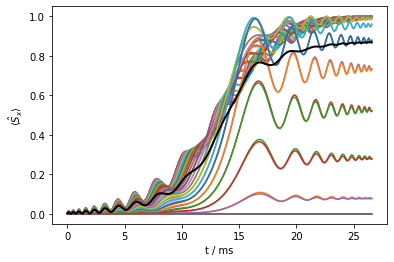

In [402]:
wt=np.sin(beta0*np.pi/180)
wt/=wt.sum()
ax=plt.plot(x,S.real.T)[0].axes
ax.plot(x,(S.T*wt).sum(-1),color='black',linewidth=2)
ax.set_xlabel('t / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')

In [441]:
print(script1)


spinsys {
  channels 13C 15N
  nuclei   13C 15N
  dipole   1 2 895 0 0 0
}

par {
  variable index   1
  np               400
  spin_rate        15000
  proton_frequency 400e6
  start_operator   I1x
  detect_operator  I2x
  method           direct
  crystal_file     rep144
  gamma_angles     1
  sw               spin_rate/2
  variable tsw     1e6/sw
  variable tr     1e6/spin_rate
  variable rfF1    75000
  variable rfF2    60000
}

proc pulseq {} {
  global par
  
  
  pulse $par(tr) $par(rfF1) x 57000 x
  acq
  pulse $par(tr) $par(rfF1) x 57118 x
  acq
  pulse $par(tr) $par(rfF1) x 57228 x
  acq
  pulse $par(tr) $par(rfF1) x 57329 x
  acq
  pulse $par(tr) $par(rfF1) x 57424 x
  acq
  pulse $par(tr) $par(rfF1) x 57512 x
  acq
  pulse $par(tr) $par(rfF1) x 57595 x
  acq
  pulse $par(tr) $par(rfF1) x 57673 x
  acq
  pulse $par(tr) $par(rfF1) x 57746 x
  acq
  pulse $par(tr) $par(rfF1) x 57815 x
  acq
  pulse $par(tr) $par(rfF1) x 57880 x
  acq
  pulse $par(tr) $par(rfF1) x 57941 x
  ac